In [31]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import arch
import datetime as dt

In [32]:
spx = pd.read_csv('^GSPC.csv', index_col=0)

In [33]:
spx['daily_chg'] = spx['Adj Close'].pct_change()

Fitting GARCH model

In [34]:
model=arch.arch_model(spx['daily_chg'][1500:]*100, vol='Garch', p=1, o=1, q=1, dist='skewt')
results=model.fit()
pd.DataFrame(results.params)

Iteration:      1,   Func. Count:      9,   Neg. LLF: 26836.9945160837
Iteration:      2,   Func. Count:     24,   Neg. LLF: 26832.12199008242
Iteration:      3,   Func. Count:     35,   Neg. LLF: 26815.127645823824
Iteration:      4,   Func. Count:     46,   Neg. LLF: 26806.145196503618
Iteration:      5,   Func. Count:     56,   Neg. LLF: 26793.497500063888
Iteration:      6,   Func. Count:     66,   Neg. LLF: 26778.540474064353
Iteration:      7,   Func. Count:     76,   Neg. LLF: 26774.319223272032
Iteration:      8,   Func. Count:     87,   Neg. LLF: 26772.3445513469
Iteration:      9,   Func. Count:     97,   Neg. LLF: 26766.883893810213
Iteration:     10,   Func. Count:    107,   Neg. LLF: 26762.98917763644
Iteration:     11,   Func. Count:    117,   Neg. LLF: 26761.72115467726
Iteration:     12,   Func. Count:    127,   Neg. LLF: 26756.082576296485
Iteration:     13,   Func. Count:    138,   Neg. LLF: 26755.805237417364
Iteration:     14,   Func. Count:    148,   Neg. LLF: 2675

,params
mu,0.037806
omega,0.009631
alpha[1],0.026977
gamma[1],0.099485
beta[1],0.914392
nu,6.171896
lambda,-0.064984


Simulating based on estimated student-t GARCH model

In [189]:
def simulate_market(years):
    '''
    Simulated a market using a gjr-garch(1,1) with a skewed t-distribution to draw error term
    
    returns
    
    a dataframe with returns, volatility, error terms and market prices given index 100 at t=0
    '''
    #setting horizon
    global horizon 
    horizon = 252*years
    market = np.empty((horizon, 1))
    market[0, 0] = 100
    rs = np.random.RandomState([892380934, 189201902, 129129894, 9890437])
    state = rs.get_state()

    dist = arch.univariate.SkewStudent(random_state=rs)
    vol = arch.univariate.GARCH(p=1, o=1, q=1)
    repro_mod = arch.univariate.ConstantMean(None, volatility=vol, distribution=dist)

    returns=repro_mod.simulate(results.params, horizon)
    for i, err in enumerate(returns["data"].values, start=1):
        if i < (horizon):
            market[i, 0] = market[i-1, 0]*(1+err/100)
    returns["Price"]=pd.DataFrame({'Price':market[:, 0]})
    return returns


Plotting

Text(0.5, 1.0, 'Volatility')

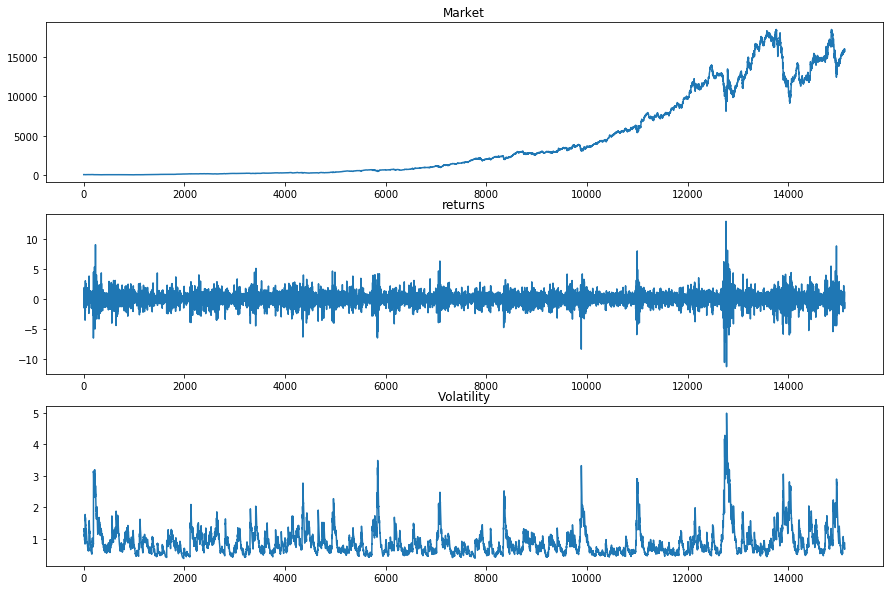

In [201]:
returns=simulate_market(60)

f, (ax1, ax2 , ax3) = plt.subplots(3, 1, figsize=(15,10))
ax1.plot(returns["Price"])
ax1.set_title('Market')
#ax1.set_yscale('log')

ax2.plot(returns["data"])
ax2.set_title('returns')
#ax2.set_yscale('LOG')

ax3.plot(returns["volatility"])
ax3.set_title('Volatility')
#ax3.set_yscale('LOG')

Simulating many markets

In [198]:
def many_market(nobs,years):
    '''
    this 
    '''
    data=pd.DataFrame({'n':range(0,horizon)})
    for i in range(0,nobs):
        data["Price" + str(i)]=simulate_market(years)["Price"] 
    return data
print(many_market(500,30))

         n      Price0      Price1       Price2       Price3       Price4  \
0        0  100.000000  100.000000   100.000000   100.000000   100.000000   
1        1  100.070753   98.880824   100.664863   100.216634   103.093068   
2        2   99.850227   98.205841   100.807431    99.389605   102.794831   
3        3   99.973693   99.059308    99.673619    99.191199   102.623659   
4        4  100.229473   98.555365    98.630007    98.871314   104.175672   
...    ...         ...         ...          ...          ...          ...   
7555  7555  913.187736  250.579974  1511.901206  1698.824243  1424.372737   
7556  7556  923.275669  251.603120  1508.826136  1655.795184  1417.648629   
7557  7557  921.399458  249.901999  1501.554777  1671.658342  1413.926710   
7558  7558  929.801790  251.173766  1514.734763  1671.949824  1422.657656   
7559  7559  924.483968  248.271673  1520.612260  1660.672155  1418.418936   

           Price5       Price6       Price7      Price8  ...     Price490  

Prospect theory utility function

In [27]:
def prospect_ut(price_before,price_after,alpha=0.88, beta=0.88, lambdas=2.25):
    '''
    in prospect theory, investors evaluate losses and gains differently. Assumes two different
    domains. Loss domain, where investment with negative returns are evaluted and gain domain for investment with positive return

    price_before:      the price in the begining of the evaluation period
    price_after:       the price in the end of the evulation period
    alpha:             risk aversion in gains
    beta:              risk seekingness in losses
    lambdas:           psycological harm of loss relativ to gains.

    example of price: price before: price of portfolio at 1st of january and price_after the price at 31st of janunary
    
    returns: utility u
    '''
    #absolute change
    x=price_after-price_before
    if x>=0: #if non negative absolute return
        u=x**alpha
    elif x<0:    #if negative absolute return
        u=-lambdas*(-x)**beta
    return u
    

In [53]:
print(prospect_ut(100,250))

82.21675051069612


Constant relative risk aversion (CRRA) utility function


In [23]:
def CRRA_ut():
    return

-31.41151724622688
